# Import modules

In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

import sys
sys.path.append('../')
from src.config import *
from src.helper_visualization import *
from src.helper_pred import *
from src.helper_pipeline import *

# Load Data

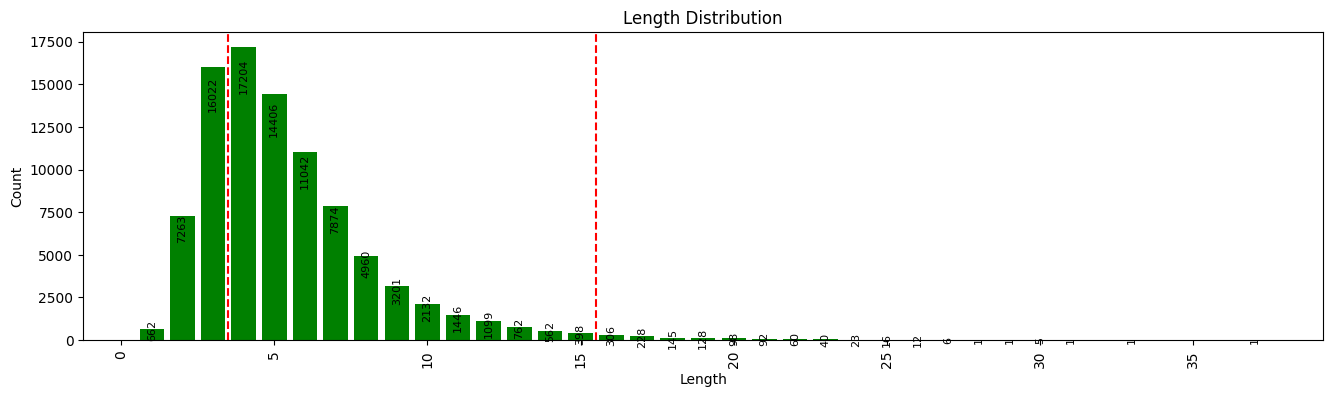

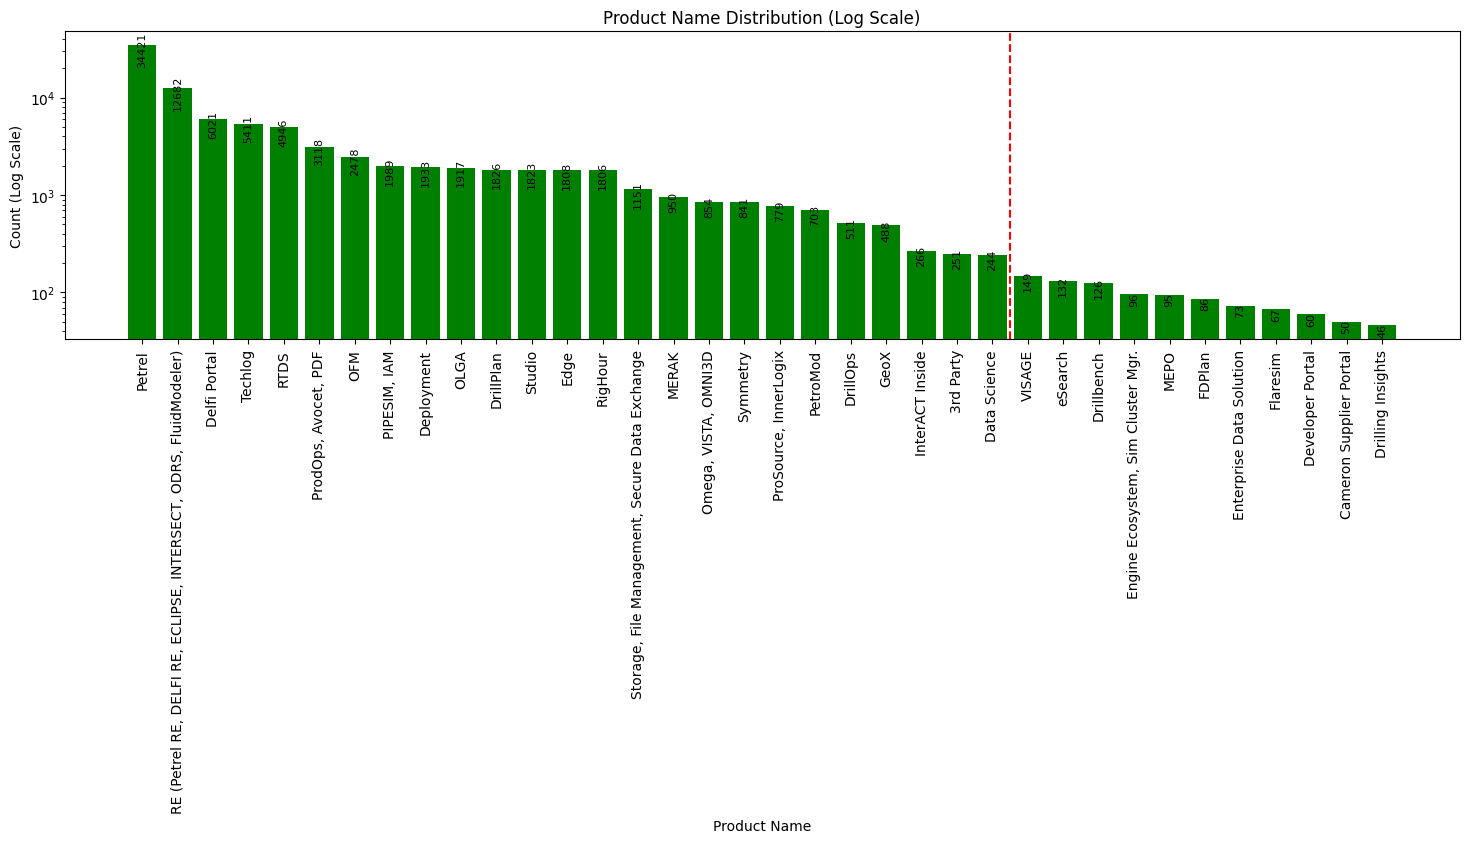

In [2]:
# Define global variables
TITLE_WORDS_MIN = 4             # the minimum number of words in the title
TITLE_WORDS_MAX = 15            # the maximum number of words in the title
TEXT_COL = 'Title_Translated'   # the text column to be used for training
TARGET_COL = 'Product Name'     # the target column to be used for training
MAX_FEATURES = 20000            # the maximum number of features for vectorizer

PRODUCT_SIZE_MAX_TRAIN = 5000   # the maximum number of samples for each product in training set to balance the data
PRODUCT_SIZE_MAX_TEST = 500     # the maximum number of samples for each product in test set to balance the data
TOP_N_PRODUCTS = 25


if 'df_train' not in locals():
    excel_file_train = f'{DATA_FOLDER_PATH_PROCESSED}/data_train.xlsx'
    df_train = pd.read_excel(excel_file_train)
    excel_file_test = f'{DATA_FOLDER_PATH_PROCESSED}/data_test.xlsx'
    df_test = pd.read_excel(excel_file_test)

hist_by_labels(df_train, 'Length', log=False, left=TITLE_WORDS_MIN-.5, right=TITLE_WORDS_MAX+.5)
hist_by_labels(df_train, 'Product Name', log=True, right=TOP_N_PRODUCTS-.5)

# Get the Product Name list of Top N products
def get_top_n_products(df, target_col, n):
    df_target = df[target_col].value_counts().to_frame().reset_index()
    df_target.columns = [target_col, 'count']
    df_target = df_target.sort_values(by='count', ascending=False)
    df_target = df_target.head(n)
    return df_target[target_col].tolist()

top_n_products = get_top_n_products(df_train, TARGET_COL, TOP_N_PRODUCTS)

# Train/Test Datasets

Pipeline Construction

In [3]:
# # create a scikit-learn pipeline to remove the title with less than 3 words or more than 20 words
pipeline_data_prep_train = Pipeline([
    ('title_length_filter', TitleLengthFilter(min_words=TITLE_WORDS_MIN, max_words=TITLE_WORDS_MAX)),
    ('other_products_combiner', OtherProductsCombiner(top_products=top_n_products, target_col=TARGET_COL)),
    ('sample_capper', SampleCapper(max_samples=PRODUCT_SIZE_MAX_TRAIN, target_col=TARGET_COL)),
    ('text_lower', TextLower(text_col=TEXT_COL))
])

pipeline_data_prep_test = Pipeline([
    ('title_length_filter', TitleLengthFilter(min_words=TITLE_WORDS_MIN, max_words=TITLE_WORDS_MAX)),
    ('other_products_combiner', OtherProductsCombiner(top_products=top_n_products, target_col=TARGET_COL)),
    ('sample_capper', SampleCapper(max_samples=PRODUCT_SIZE_MAX_TEST, target_col=TARGET_COL)),
    ('text_lower', TextLower(text_col=TEXT_COL))
])

display(pipeline_data_prep_train)
display(pipeline_data_prep_test)

Pipeline(steps=[('title_length_filter',
                 TitleLengthFilter(max_words=15, min_words=4)),
                ('other_products_combiner',
                 OtherProductsCombiner(target_col='Product Name',
                                       top_products=['Petrel',
                                                     'RE (Petrel RE, DELFI RE, '
                                                     'ECLIPSE, INTERSECT, '
                                                     'ODRS, FluidModeler)',
                                                     'Delfi Portal', 'Techlog',
                                                     'RTDS',
                                                     'ProdOps, Avocet, PDF',
                                                     'OFM', 'PIPESIM, IAM',
                                                     'Deployment', 'OLGA',
                                                     'DrillPlan', 'Studio',
                                                     'Edge', 'RigHour',
                                                     'Storage, File '
                                                     'Management, Secure Data '
                                                     'Exchange',
                                                     'MERAK',
                                                     'Omega, VISTA, OMNI3D',
                                                     'Symmetry',
                                                     'ProSource, InnerLogix',
                                                     'PetroMod', 'DrillOps',
                                                     'GeoX', 'InterACT Inside',
                                                     '3rd Party',
                                                     'Data Science'])),
                ('sample_capper',
                 SampleCapper(max_samples=2000, target_col='Product Name')),
                ('text_lower', TextLower(text_col='Title_Translated'))])

Pipeline(steps=[('title_length_filter',
                 TitleLengthFilter(max_words=15, min_words=4)),
                ('other_products_combiner',
                 OtherProductsCombiner(target_col='Product Name',
                                       top_products=['Petrel',
                                                     'RE (Petrel RE, DELFI RE, '
                                                     'ECLIPSE, INTERSECT, '
                                                     'ODRS, FluidModeler)',
                                                     'Delfi Portal', 'Techlog',
                                                     'RTDS',
                                                     'ProdOps, Avocet, PDF',
                                                     'OFM', 'PIPESIM, IAM',
                                                     'Deployment', 'OLGA',
                                                     'DrillPlan', 'Studio',
                                                     'Edge', 'RigHour',
                                                     'Storage, File '
                                                     'Management, Secure Data '
                                                     'Exchange',
                                                     'MERAK',
                                                     'Omega, VISTA, OMNI3D',
                                                     'Symmetry',
                                                     'ProSource, InnerLogix',
                                                     'PetroMod', 'DrillOps',
                                                     'GeoX', 'InterACT Inside',
                                                     '3rd Party',
                                                     'Data Science'])),
                ('sample_capper', SampleCapper(target_col='Product Name')),
                ('text_lower', TextLower(text_col='Title_Translated'))])

Data Processing

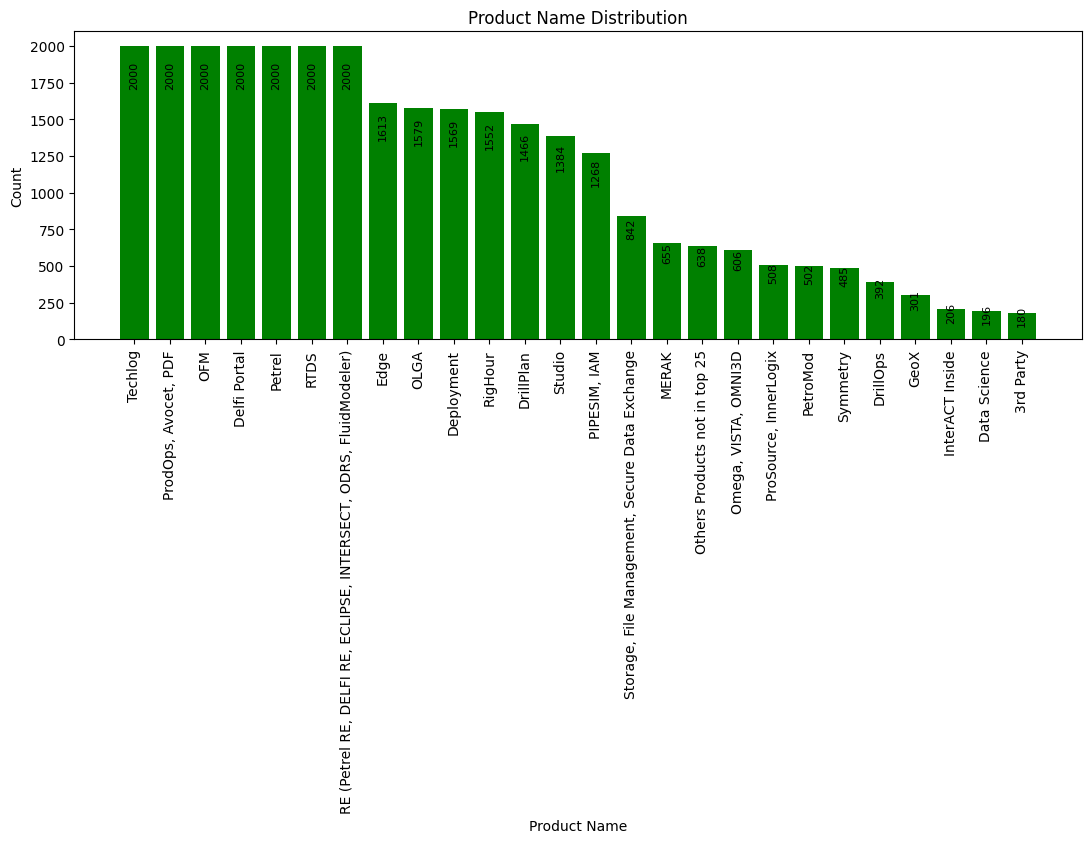

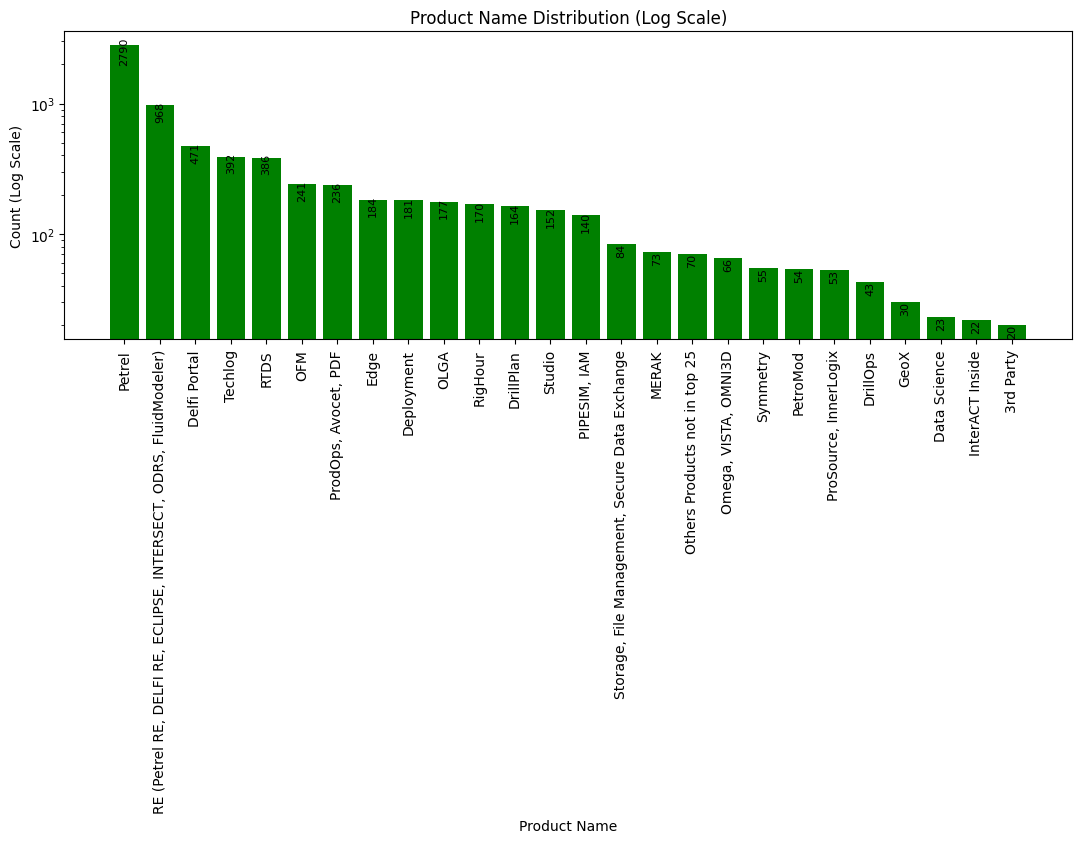

In [5]:
train_data = pipeline_data_prep_train.fit_transform(df_train)
test_data = pipeline_data_prep_test.fit_transform(df_test)
hist_by_labels(train_data, TARGET_COL, log=False, horizontal=True)
hist_by_labels(test_data, TARGET_COL, log=True, horizontal=True)

# Model Baseline - Cross Validation

In [6]:
# SciKit-Learn
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

# Optuna
import optuna
import optuna.visualization as vis

# Others
import pickle

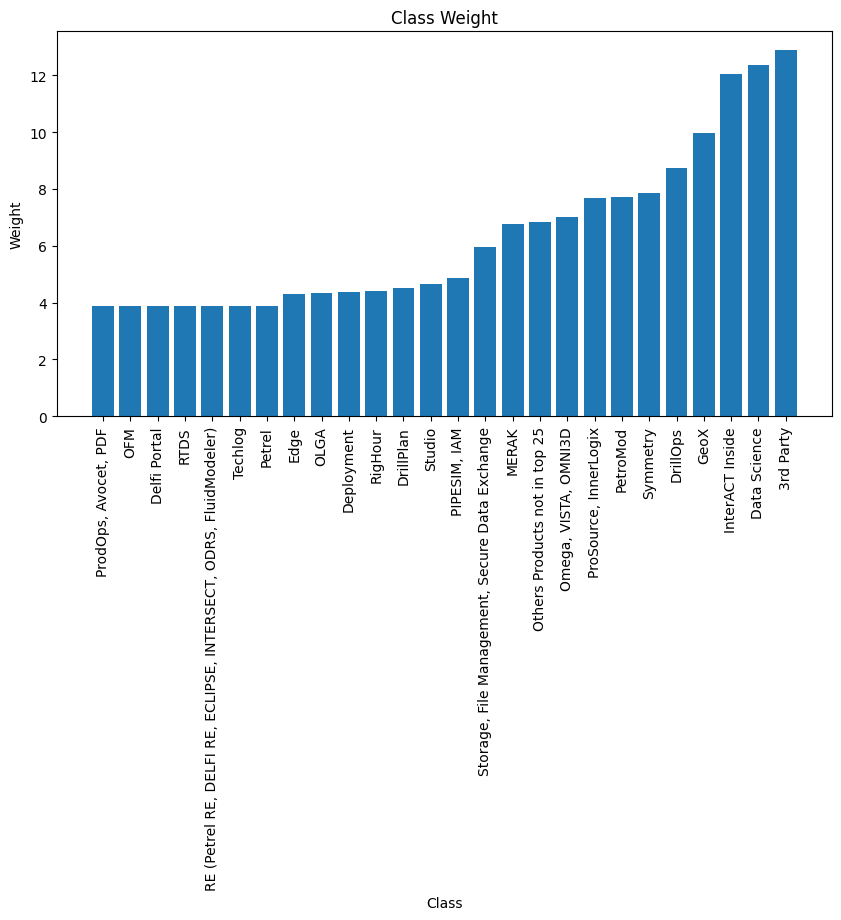

In [7]:
# create vectorizer for text
vectorizer_countvec = CountVectorizer(max_features=MAX_FEATURES, analyzer='word', ngram_range=(1, 2))
vectorizer_tfidf = TfidfVectorizer(max_features=MAX_FEATURES, analyzer='word', ngram_range=(1, 2))

X = df_train[TEXT_COL]
vectorizer_countvec.fit(X)
vectorizer_tfidf.fit(X)

vectorizer = vectorizer_tfidf

X_train = train_data[TEXT_COL]
y_train = train_data[TARGET_COL]
X_train_encoded = vectorizer.transform(X_train)

X_test = test_data[TEXT_COL]
X_test_encoded = vectorizer.transform(X_test)
y_test = test_data[TARGET_COL]

# calculate the class weight of X_train
class_weight = dict()
for label in y_train.unique():
    class_weight[label] = len(y_train)/len(y_train[y_train==label])

# apply sqrt() to the class weight
for label in class_weight.keys():
    class_weight[label] = np.sqrt(class_weight[label])
plot_class_weights(class_weight)

In [8]:
# create a dictionary of models
models = {
    'SGDClassifier': SGDClassifier(max_iter=5000, class_weight=class_weight ),
    'LogisticRegression': LogisticRegression(max_iter=5000, class_weight=class_weight),
    'SVC linear': SVC(kernel='linear', class_weight=class_weight),
    # 'RandomForestClassifier': RandomForestClassifier(),
    # 'GradientBoostingClassifier': GradientBoostingClassifier(),
    # 'MultinomialNB': MultinomialNB(class_weight=class_weight)
    # 'SVC rbf': SVC(kernel='rbf'),
}

print(f'Configuration: Classify top \033[94m{TOP_N_PRODUCTS}\033[0m products; Text column: \033[94m{TEXT_COL}\033[0m, Title words length: (\033[94m{TITLE_WORDS_MIN}\033[0m, \033[94m{TITLE_WORDS_MAX}\033[0m); Records/product caped at \033[94m{PRODUCT_SIZE_MAX_TRAIN}\033[0m')
print('Baseline Score(s) of each model are ....')

for model in models:
    cv_result = cross_val_score(
        models[model], 
        X_train_encoded,
        y_train, #the target
        cv=5, 
        scoring='accuracy', # lease revise to the appropriate score
        n_jobs=-1
    )
    print(f'Average score: \033[94m{"{:.4f}".format(np.mean(cv_result))}\033[0m by \033[94m{model}\033[0m.')

Configuration: Classify top 25 products; Text column: Title_Translated, Title words length: (4, 15); Records/product caped at 2000
Baseline Score(s) of each model are ....
Average score: 0.8242 by SGDClassifier.
Average score: 0.8201 by LogisticRegression.
Average score: 0.8039 by SVC linear.


In [ ]:
# Configuration: TITLE_WORDS_MIN=4, TITLE_WORDS_MAX=15, TEXT_COL=Title_Translated, PRODUCT_SIZE_MAX_TRAIN=2000, TOP_N_PRODUCTS=25.
# Baseline Score(s) of each model are ....
# Average score: 0.8245 by SGDClassifier.
# Average score: 0.8193 by LogisticRegression.
# Average score: 0.8038 by SVC linear.

# Baseline Score(s) of each model are .... TITLE_WORDS_MIN=4, TITLE_WORDS_MAX = 15 Title_Translated, with class_weight, 
# Average score: 0.8242 by SGDClassifier.
# Average score: 0.8193 by LogisticRegression.
# Average score: 0.8038 by SVC linear.

# Baseline Score(s) of each model are .... TITLE_WORDS_MIN=4, TITLE_WORDS_MAX = 15 Title_Translated
# Average score: 0.8206 by SGDClassifier.
# Average score: 0.8121 by SVC linear.
# Average score: 0.8018 by LogisticRegression.

# Baseline Score(s) of each model are .... TITLE_WORDS_MIN=4, TITLE_WORDS_MAX = 15 Title_Translated
# Average score: 0.8196 by SGDClassifier.
# Average score: 0.8108 by SVC linear.
# Average score: 0.7994 by LogisticRegression.

# Baseline Score(s) of each model are .... TITLE_WORDS_MIN=3, TITLE_WORDS_MAX = 15 Title_Translated
# Average score: 0.8091 by SGDClassifier.
# Average score: 0.8030 by SVC linear.
# Average score: 0.7921 by LogisticRegression.

# Baseline Score(s) of each model are .... TITLE_WORDS_MIN=4, TITLE_WORDS_MAX = 15 Title_Enhanced
# Baseline Score(s) of each model are .... 3000 samples per product max
# Average score: 0.8144 by SGDClassifier.
# Average score: 0.8134 by SVC linear.
# Average score: 0.8013 by LogisticRegression.

# Average score: 0.8150 by SGDClassifier.  2000 samples per product max
# Average score: 0.8098 by SVC linear.
# Average score: 0.7996 by LogisticRegression.

# Baseline Score(s) of each model are .... TITLE_WORDS_MIN=3, TITLE_WORDS_MAX = 15 Title_Enhanced
# Average score: 0.8050 by SGDClassifier.
# Average score: 0.8021 by SVC linear.
# Average score: 0.7909 by LogisticRegression.

# Hpyerparameter Tuning

## SGC Classifier (2min)

In [ ]:
# Clean up the study if it exists
study_name = 'sgd_classifier'
storage_name = 'sqlite:///optuna_study.db'

try:
    optuna.delete_study(study_name=study_name, storage=storage_name)
except:
    pass

In [ ]:
# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space

    pamams = {
        'alpha': trial.suggest_float('alpha', 1e-7, 1e-3, log=True),
        'eta0': trial.suggest_float('eta0', 1e-3, 1e-1, log=True),
        'loss': trial.suggest_categorical('loss', ['log_loss', 'modified_huber', 'hinge']), #square_hinge doesn't work with model.predict_proba() and is very slow
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'optimal', 'adaptive']), #
        'max_iter': 10000,
        'random_state': 42
        }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    sgd_classifier = SGDClassifier(class_weight=class_weight, **pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(sgd_classifier, X_train_encoded, y_train, cv=5, scoring='accuracy')
    
    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize', study_name=study_name, storage=storage_name, load_if_exists=True)

study.optimize(
    objective,
    n_trials=100, 
    n_jobs=-1, 
    show_progress_bar=True
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_sore = study.best_value
print("Best Hyperparameters:", best_params)
print("Best Score:", best_sore)

In [ ]:
vis.plot_optimization_history(study)

In [ ]:
vis.plot_slice(study)

In [ ]:
# Create and train the best Logistic Regression model
best_model_sgc = SGDClassifier(class_weight=class_weight, **best_params)
best_model_sgc.fit(X_train_encoded, y_train)

# Predict categories for the test data
y_pred_sgc = best_model_sgc.predict(X_test_encoded)

accuracy = accuracy_score(y_test, y_pred_sgc)
print(f'Accuracy: \033[94m{accuracy:4f}\033[0m on test data size \033[94m{len(y_test)}\033[0m')

# Evaluate the classifier's performance
print(classification_report(y_test, y_pred_sgc, digits=3))
plot_confusion_matrix(y_test, y_pred_sgc, title='Confusion matrix for Rests')
df_pred_top5_sgc = top5_accuracy_report(best_model_sgc, vectorizer, X_test, y_test, pre_processed=True)

In [ ]:
# Accuracy of top 1 prediction is 0.812.
# Accuracy of top 3 prediction is 0.932.
# Accuracy of top 5 prediction is 0.959.
# export the model
pickle.dump(best_model_sgc, open(f'{MODEL_FOLDER_PATH}/model_sgc_classifier.pkl', 'wb'))
pickle.dump(vectorizer_tfidf, open(f'{MODEL_FOLDER_PATH}/vectorizer_sgc_classifier.pkl', 'wb'))

## Logistic Classification (10min/10trials)

In [ ]:
# Clean up the study if it exists
study_name = 'logReg'
storage_name = 'sqlite:///optuna_study.db'
try:
    optuna.delete_study(study_name=study_name, storage=storage_name)
except:
    pass 

In [ ]:
# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space

    pamams = {
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'saga']), #sag is slow
        'C': trial.suggest_float('C', 1e-2, 1e+2, log=True),
        'penalty': 'l2',
        'multi_class': 'ovr',
        'max_iter': 5000,
        'random_state': 42
    }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    logReg = LogisticRegression(class_weight=class_weight, **pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(logReg, X_train_encoded, y_train, cv=5, scoring='accuracy')

    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize', study_name=study_name, storage=storage_name, load_if_exists=True)

study.optimize(
    objective,
    n_trials=10, 
    n_jobs=-1, 
    show_progress_bar=True,
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_accuracy = study.best_value
print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

In [ ]:
vis.plot_optimization_history(study)

In [ ]:
vis.plot_slice(study)

In [ ]:
# Create and train the best Logistic Regression model
best_model_logReg= LogisticRegression(class_weight=class_weight, **best_params)
best_model_logReg.fit(X_train_encoded, y_train)

# Step 4: Model Evaluation
y_pred_logReg = best_model_logReg.predict(X_test_encoded)
accuracy = accuracy_score(y_test, y_pred_logReg)
print(f'Accuracy: \033[94m{accuracy:.4f}\033[0m')

report = classification_report(y_test, y_pred_logReg, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_logReg, title='Confusion matrix for Rests')
df_pred_top5_logReg = top5_accuracy_report(best_model_logReg, vectorizer_tfidf, X_test, y_test, pre_processed=True)

In [ ]:
# Accuracy of top 1 prediction is 0.817.
# Accuracy of top 3 prediction is 0.934.
# Accuracy of top 5 prediction is 0.961.
# export the model
pickle.dump(best_model_logReg, open(f'{MODEL_FOLDER_PATH}/model_logistic_regression.pkl', 'wb'))
pickle.dump(vectorizer_tfidf, open(f'{MODEL_FOLDER_PATH}/vectorizer_logistic_regression.pkl', 'wb'))

## MultinomialNB (2min)

In [ ]:
# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space of MultinomialNB model
    pamams = {
        'alpha': trial.suggest_float('alpha', 1e-6, 1e+2, log=True),
        'fit_prior': trial.suggest_categorical('fit_prior', [True, False])
    }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    model_multinomialNB = MultinomialNB(**pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(model_multinomialNB, X_train_encoded, y_train, cv=5, scoring='accuracy')

    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(
    objective,
    n_trials=250, 
    n_jobs=-1, 
    show_progress_bar=True,
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_accuracy = study.best_value

# Create and train the best Logistic Regression model
best_model_multinomialNB = MultinomialNB(**best_params)
best_model_multinomialNB.fit(X_train_encoded, y_train)
print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

In [ ]:
# weights = df_rests['ProductName'].value_counts().apply(np.sqrt).to_dict()
model_multinomialNB = best_model_multinomialNB

# Step 4: Model Evaluation
y_pred_multinomialNB = model_multinomialNB.predict(X_test_encoded)
accuracy = accuracy_score(y_test, y_pred_multinomialNB)
print(f'Accuracy: \033[94m{accuracy:4f}\033[0m')

report = classification_report(y_test, y_pred_multinomialNB, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_multinomialNB, title='Confusion matrix for Rests')
df_pred_top5_multinomialNB = top5_accuracy_report(model_multinomialNB, vectorizer_tfidf, X_test, y_test, pre_processed=True)

In [ ]:
# Accuracy of top 1 prediction is 0.789.
# Accuracy of top 3 prediction is 0.927.
# Accuracy of top 5 prediction is 0.956.
# export the model and the vectorizer
pickle.dump(best_model_multinomialNB, open(f'{MODEL_FOLDER_PATH}/model_multinomialNB.pkl', 'wb'))
pickle.dump(vectorizer_countvec, open(f'{MODEL_FOLDER_PATH}/vectorizer_multinomialNB.pkl', 'wb'))

## SVC Linear (>60min)

In [ ]:
# user Optuna to tune the hyperparameters for SVC Linear
study_name = 'SVC_linear'
storage_name = 'sqlite:///optuna_study.db'

# Clean up the study if it exists
try:
    optuna.delete_study(study_name=study_name, storage=storage_name)
except:
    pass

In [ ]:
# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space

    pamams = {
        'C': trial.suggest_float('C', 1, 2, log=True),
        'max_iter': 50000,
        'random_state': 42,
    }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    model_svc_linear = SVC(kernel='linear', probability=True, **pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(model_svc_linear, X_train_encoded, y_train, cv=5, scoring='accuracy')

    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize', study_name=study_name, storage=storage_name, load_if_exists=True)
study.optimize(
    objective,
    n_trials=10, 
    n_jobs=-1, 
    show_progress_bar=True
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_accuracy = study.best_value

print("Best Hyperparameters:", best_params)

# Create and train the best Logistic Regression model
best_model_svc_linear = SVC(kernel='linear', **best_params)
best_model_svc_linear.fit(X_train_encoded, y_train)

In [ ]:
vis.plot_optimization_history(study)

In [ ]:
vis.plot_slice(study)

In [ ]:
best_model_svc_linear = SVC(kernel='linear', probability=True, **best_params)
# best_model_svc_linear = SVC(kernel='linear', probability=True)
best_model_svc_linear.fit(X_train_encoded, y_train)

# Step 4: Model Evaluation
y_pred_svc_linear = best_model_svc_linear.predict(X_test_encoded)
accuracy = accuracy_score(y_test, y_pred_svc_linear)
print(f'Accuracy: \033[94m{accuracy:4f}\033[0m')

report = classification_report(y_test, y_pred_svc_linear, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_svc_linear, title='Confusion matrix for Rests')
df_pred_top5_svc_linear = top5_accuracy_report(best_model_svc_linear, vectorizer_tfidf, X_test, y_test, pre_processed=True)

In [ ]:
# Accuracy of top 1 prediction is 0.816.
# Accuracy of top 3 prediction is 0.935.
# Accuracy of top 5 prediction is 0.964.
pickle.dump(best_model_svc_linear, open(f'{MODEL_FOLDER_PATH}/model_svc_linear.pkl', 'wb'))
pickle.dump(vectorizer_tfidf, open(f'{MODEL_FOLDER_PATH}/vectorizer_svc_linear.pkl', 'wb'))

## RandomForestClassifier

In [ ]:
# user Optuna to tune the hyperparameters for RandomForestClassifier

# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space

    pamams = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 4000, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 32, log=True),
        # 'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        # 'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': 42,
    }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    model_random_forest = RandomForestClassifier(**pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(model_random_forest, X_train_encoded, y_train, cv=5, scoring='accuracy')

    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(
    objective,
    n_trials=10, 
    n_jobs=-1, 
    show_progress_bar=True
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_accuracy = study.best_value
print("Best Hyperparameters:", best_params)

best_model_random_forest = RandomForestClassifier(**best_params)
best_model_random_forest.fit(X_train_encoded, y_train)

# Step 4: Model Evaluation
y_pred_random_forest = best_model_random_forest.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred_random_forest)
print(f'Accuracy: \033[94m{accuracy:4f}\033[0m')

report = classification_report(y_test, y_pred_random_forest, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_random_forest, title='Confusion matrix for Rests')
df_pred_top5_random_forest = top5_accuracy_report(best_model_random_forest, vectorizer_tfidf, X_test, y_test, pre_processed=True)

pickle.dump(best_model_random_forest, open(f'{MODEL_FOLDER_PATH}/model_random_forest.pkl', 'wb'))
pickle.dump(vectorizer_tfidf, open(f'{MODEL_FOLDER_PATH}/vectorizer_random_forest.pkl', 'wb'))

## Voting model

In [ ]:
# now we have three models, logistic regression, multinomialNB and svc_linear, we can use voting classifier to combine them together
from sklearn.ensemble import VotingClassifier

# Create a dictionary of the models
estimators = [
    ('logReg', best_model_logReg),
    ('svc_linear', best_model_svc_linear),
    ('sgc_classifier', best_model_sgc),
]

# Create a voting classifier
voting = VotingClassifier(estimators, voting='soft', n_jobs=-1)

# Fit the voting classifier to the training data
voting.fit(X_train_encoded, y_train)

# Step 4: Model Evaluation
y_pred_voting = voting.predict(X_test_encoded)
accuracy = accuracy_score(y_test, y_pred_voting)
print(f'Accuracy: \033[94m{accuracy:.4f}\033[0m')

report = classification_report(y_test, y_pred_voting, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_voting, title='Confusion matrix for Rests')

df_pred_top5_voting = top5_accuracy_report(voting, vectorizer, X_test, y_test, pre_processed=True)

In [ ]:
# Accuracy of top 1 prediction is 0.824.
# Accuracy of top 3 prediction is 0.936.
# Accuracy of top 5 prediction is 0.963.
pickle.dump(voting, open(f'{MODEL_FOLDER_PATH}/model_voting.pkl', 'wb'))
pickle.dump(vectorizer_tfidf, open(f'{MODEL_FOLDER_PATH}/vectorizer_voting.pkl', 'wb'))